<a href="https://colab.research.google.com/github/i-am-adithyavardhan/MiniProject_3rdYear/blob/main/bertHasoc2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
filePath = '/content/drive/MyDrive/HasocDataset/hindi_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')
df1 = df1.drop('task_2',axis=1)
df1.columns = ['ID','TwitterID','HASOCID','Text','Type']
df = df1.drop(['ID','TwitterID','HASOCID'],axis=1)

In [ ]:
df.head()

,Text,Type
0,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT
1,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT
2,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT
3,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF
4,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT


In [ ]:
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)
df.head()

,Text,Type
0,@rssurjewala #Hindus DYING #HindusLivesMatter ...,1
1,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,1
2,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,1
3,@AskAnshul आसमानी किताब के नाजायज औलाद है।,0
4,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,1


In [ ]:
X = list(df['Text'].values)
y = list(df['Type'].values)

Train Validation Test Split

In [ ]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = 0.10, random_state=42,stratify=y) #80% train 10% test 10% validation
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, test_size = 0.111, random_state=42,stratify=y_tmp)
print(len(X_train))
print(len(X_valid))
print(len(X_test))

3675
459
460


Model

In [ ]:
model_name = 'bert-base-multilingual-cased'

In [ ]:
def generate_dataset(X,y, tokenizer):
  #Generate encodings
  encodings = tokenizer.batch_encode_plus(X,truncation = True,padding=True,max_length=128,return_tensors='pt',add_special_tokens = True)

  #convert to tensor dataset
  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']

  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)
  y = torch.tensor(y)

  dataset = TensorDataset(input_ids,attention_mask,y)

  return dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
train_dataset = generate_dataset(X_train,y_train,tokenizer)
valid_dataset = generate_dataset(X_valid,y_valid,tokenizer)

<ipython-input-11-9c3d998b3cdd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-11-9c3d998b3cdd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
def get_data_loader(dataset,sampler):
  return DataLoader(dataset=dataset,sampler=sampler(dataset),batch_size=32)

In [ ]:
train_loader = get_data_loader(train_dataset,RandomSampler)
validation_loader = get_data_loader(valid_dataset,SequentialSampler)

Importing Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,eps=1e-8)

num_epochs = 8
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Function for Training on Training Data

In [ ]:
def train():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  num_steps = 0

  for step,batch in enumerate(train_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc

Function for training on Validation Data

In [ ]:
def evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
  
  train_loss, train_acc = train()
  valid_loss, valid_acc,f1_score = evaluate()

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)

  if f1_score > best_f1:
      best_f1 = f1_score
      torch.save(model,'/content/drive/MyDrive/HasocDataset/Models/hindi_model_bert.pt')


  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f} ')


 Epoch 1 / 8
  Batch    50  of    115.
  Batch   100  of    115.

Training Accuracy: 0.747 | Training Loss: 0.535 | Validation Accuracy: 0.777 | Validation Loss: 0.483 | F1 Score: 0.711 

 Epoch 2 / 8
  Batch    50  of    115.
  Batch   100  of    115.

Training Accuracy: 0.803 | Training Loss: 0.427 | Validation Accuracy: 0.777 | Validation Loss: 0.496 | F1 Score: 0.670 

 Epoch 3 / 8
  Batch    50  of    115.
  Batch   100  of    115.

Training Accuracy: 0.855 | Training Loss: 0.345 | Validation Accuracy: 0.802 | Validation Loss: 0.459 | F1 Score: 0.744 

 Epoch 4 / 8
  Batch    50  of    115.
  Batch   100  of    115.

Training Accuracy: 0.899 | Training Loss: 0.262 | Validation Accuracy: 0.761 | Validation Loss: 0.556 | F1 Score: 0.712 

 Epoch 5 / 8
  Batch    50  of    115.
  Batch   100  of    115.

Training Accuracy: 0.926 | Training Loss: 0.197 | Validation Accuracy: 0.785 | Validation Loss: 0.644 | F1 Score: 0.704 

 Epoch 6 / 8
  Batch    50  of    115.
  Batch   100  of   

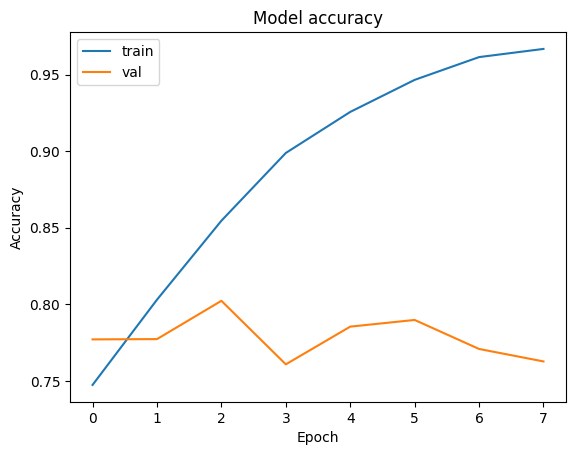

In [ ]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

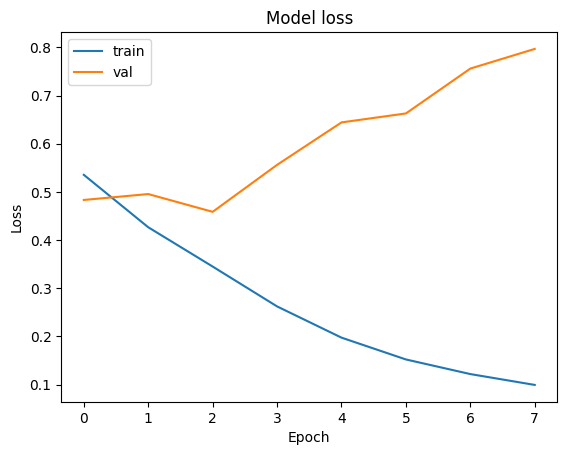

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
del model
del train_loader
del validation_loader

import gc
gc.collect()

48

In [ ]:
#category wise accuracy table

In [ ]:
path = "/content/drive/MyDrive/HasocDataset/Models/bertNew.pt"
torch.save(model,path)

In [ ]:
model = torch.load('/content/drive/MyDrive/HasocDataset/Models/bertNew.pt')
model = model.to(device)

In [ ]:
test_dataset = generate_dataset(X_test,y_test,tokenizer)
test_loader = get_data_loader(test_dataset,SequentialSampler)

<ipython-input-11-9c3d998b3cdd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-11-9c3d998b3cdd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
def test_evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(test_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(test_loader)
  avg_acc = total_acc/len(test_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [ ]:
test_loss,test_acc,f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f} ')


Test Accuracy: 0.788 | Test Loss: 0.644 | F1 Score: 0.753 
